<div style="text-align: right"><b> Jessenia Piza Londoño, Paula Lorena López Romero & Laura Alejandra Salazar Pérez. </b></div>

# Taller 2 de NLP: Word2Vec

Para este taller deberás disponer de algunas librerías como scikit-learn, NLTK, y GenSim. Se recomienda revisar la [documentación de GenSim](https://radimrehurek.com/gensim/auto_examples/index.html#documentation).

## Cargando un modelo  en GenSim y análisis
A continuación cargaremos un modelo que no pesa tanto `glove-twitter-50`. Hay modelos más completos y con mayor número de dimensiones en este [link](https://github.com/RaRe-Technologies/gensim-data)

In [63]:
import gensim.downloader as api
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
wv = api.load("glove-twitter-50")

Una operación común es recuperar el vocabulario de un modelo. Eso es trivial:

In [3]:
for index, word in enumerate(wv.index_to_key):
    if index == 20:
        break
    print(f"palabra #{index}/{len(wv.index_to_key)} es {word}")

palabra #0/1193514 es <user>
palabra #1/1193514 es .
palabra #2/1193514 es :
palabra #3/1193514 es rt
palabra #4/1193514 es ,
palabra #5/1193514 es <repeat>
palabra #6/1193514 es <hashtag>
palabra #7/1193514 es <number>
palabra #8/1193514 es <url>
palabra #9/1193514 es !
palabra #10/1193514 es i
palabra #11/1193514 es a
palabra #12/1193514 es "
palabra #13/1193514 es the
palabra #14/1193514 es ?
palabra #15/1193514 es you
palabra #16/1193514 es to
palabra #17/1193514 es (
palabra #18/1193514 es <allcaps>
palabra #19/1193514 es <elong>


In [4]:
vec_king = wv['king']

In [5]:
vec_king

array([-0.77201  , -0.16548  ,  0.22263  , -0.56608  ,  0.15602  ,
       -0.050659 ,  0.076896 ,  0.90058  , -0.22829  , -0.083794 ,
       -0.0087308,  0.12425  , -3.6283   , -0.70631  ,  0.3391   ,
       -0.26866  ,  0.012886 ,  0.1314   ,  0.13072  ,  0.1594   ,
       -0.43884  ,  0.30631  , -0.51841  , -0.86402  ,  0.89706  ,
       -0.29222  ,  0.071633 , -0.7285   ,  0.47514  , -0.54581  ,
        0.37375  , -0.2815   , -0.82164  , -0.1245   ,  0.06561  ,
        0.2686   ,  0.12587  , -0.50189  ,  0.41322  , -0.40509  ,
       -0.88866  , -0.71627  , -0.010728 , -0.29513  ,  0.098062 ,
        0.47936  ,  0.49517  , -0.30246  ,  0.37465  ,  0.010619 ],
      dtype=float32)

Desafortunadamente, el modelo no puede inferir vectores para palabras desconocidas. Esta es una limitación de Word2Vec: si esta limitación le importa, consulte el modelo FastText.

In [6]:
wv["sanime"]

KeyError: "Key 'sanime' not present"

Continuando, Word2Vec admite varias tareas de similitud de palabras listas para usar. Puedes ver cómo la similitud (¿Que similitud será?) disminuye intuitivamente a medida que las palabras se vuelven cada vez menos similares.

In [7]:
pairs = [
    ('gato', 'perro'),   
    ('gato', 'tigre'),   
    ('gato', 'rana'),  
    ('gato', 'nube'),   
    ('gato', 'politica'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'gato'	'perro'	0.85
'gato'	'tigre'	0.65
'gato'	'rana'	0.38
'gato'	'nube'	0.28
'gato'	'politica'	0.15


Podemos encontrar las palabras más similares de acuerdo a una medida de similaridad ([la similaridad del coseno](https://en.wikipedia.org/wiki/Cosine_similarity)):

In [8]:
pd.DataFrame(wv.most_similar(positive=['carro', 'camión'], topn=5), columns=["palabra", "similaridad"])

,palabra,similaridad
0,camion,0.847325
1,coche,0.836260
2,autobús,0.834142
3,helicóptero,0.820165
4,avión,0.792418


¿Cuál de estos no pertenece a la secuencia?

In [9]:
print(wv.doesnt_match(['fuego', 'agua', 'tierra', 'mar', 'aire', 'carro']))

carro


### Analogias

Se ha demostrado que los vectores de palabras *a veces* exhiben la capacidad de resolver analogías.

Como ejemplo, para la analogía "hombre: rey :: mujer: x" (léase: el hombre es al rey como la mujer es a x), ¿qué es x?

En la celda a continuación, se muestra cómo usar vectores de palabras para encontrar x usando la función `most_similar` de la [documentacion de GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similares). La función encuentra palabras que son más similares a las palabras en la lista "positiva" y más diferentes de las palabras en la lista "negativa" (mientras omite las palabras de entrada, que a menudo son las más similares). La respuesta a la analogía tendrá la mayor similitud del coseno (mayor valor numérico devuelto).

In [10]:
# esta es la analogia -- hombre : rey :: mujer : x
wv.most_similar(positive=['mujer', 'rey'], negative=['hombre'])

[('reina', 0.823491632938385),
 ('diana', 0.724789559841156),
 ('victoria', 0.724120557308197),
 ('shakira', 0.716420590877533),
 ('chica', 0.7134189009666443),
 ('luna', 0.6988049149513245),
 ('colombiana', 0.6971471905708313),
 ('canción', 0.6866006851196289),
 ('dulce', 0.6847524046897888),
 ('karina', 0.6814141869544983)]

#### Ejercicio 1
Cree una función denominada `analogia(a,b,c)` donde determine la analogía *a* : *b* :: *c* : *d*, es decir retorne a *d*, como en el ejemplo anterior. Pruebe la función con 5 analogías que se le ocurra (en inglés o en españól, pero no combinadas)

In [11]:
def analogia(a, b, c):
    similar = wv.most_similar(positive=[c, b], negative=[a])
    return c, similar[0][0]

In [12]:
analogia('moto', 'carro', 'suzuki')

('suzuki', 'camaro')

In [13]:
analogia('maleta', 'chaqueta', 'jansport')

('jansport', 'croco')

In [14]:
analogia('asia', 'europa', 'japon')

('japon', 'francia')

In [15]:
analogia('vino', 'tequila', 'prosecco')

('prosecco', 'champers')

In [16]:
analogia('brasil', 'argentina', 'neymar')


('neymar', 'cristiano')

In [17]:
analogia('celular', 'computador', 'samsung')

('samsung', 'nexus')

#### Ejercicio 2
Haga un listado de unas 20 palabras y grafiquelas en dos dimensiones (colocando su texto) junto con unas 200 palabras muestreadas aleatoriamente (sin texto). Use para reducir la dimensión PCA. Repita lo mismo usando TSNE.

In [18]:
word_list = wv.index_to_key[1395:1415]
words_list = [wv.get_vector(i) for i in word_list]
np.random.seed(0)
index = np.random.randint(0, len(wv.index_to_key), (1, 200))
words = [wv.get_vector(wv.index_to_key[i]) for i in index[0]]

In [19]:
pca200 = PCA(n_components=2)
X200_pca = pca200.fit_transform(words)

In [20]:
X20_pca = pca200.transform(words_list)

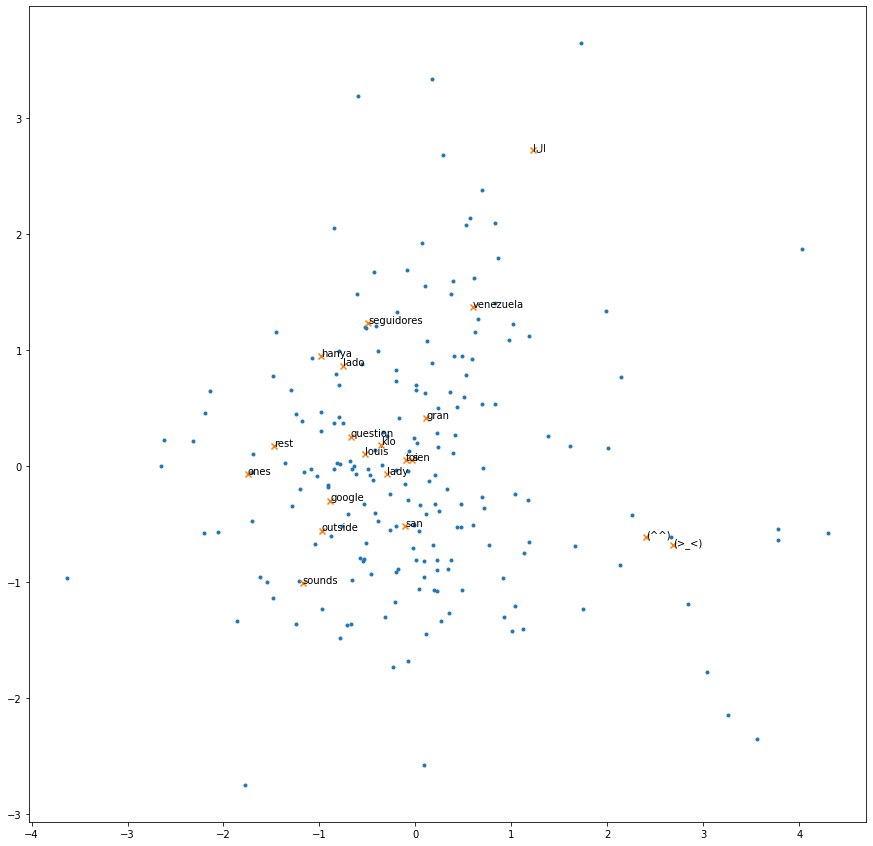

In [21]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X200_pca[:,0], X200_pca[:,1],marker='.')
ax.scatter(X20_pca[:,0], X20_pca[:,1],marker='x')

for i, txt in enumerate(word_list):
    ax.annotate(txt, (X20_pca[i, 0], X20_pca[i, 1]))

-----

GenSim permite acceder a las palabras mediante diferentes formas sobre un objeto `KeyedVectors` (el wv de antes es uno). `.index_to_key`produce una lista con el vocabulario de forma ordenada, mientras `.key_to_index` produce un diccionario de la forma {palabra: index}.

In [22]:
print(wv.index_to_key[100:120])

['_', 'mi', 'can', '<sadface>', 'من', '♡', '´', 'he', 'con', 'they', 'now', 'go', '،', 'para', 'los', 'know', 'haha', 'good', 'tu', 'back']


## Entrene un nuevo modelo sobre un corpus

Trabajaremos de nuevo con el dataset de `progressive-tweet-sentiment.csv`, el cuál es un dataset pequeño que nos facilitará probar Word2vec. Sin embargo, los resultados pueden no ser tan buenos, dado que Word2vec es más potente cuando el corpus es más grande.

`progressive-tweet-sentiment`  tiene algunos tweets recopilados y categorizados en 4 clases: 'Legalization of Abortion', 'Hillary Clinton', 'Feminist Movement', 'Atheism'. 

In [23]:
df = pd.read_csv("progressive-tweet-sentiment.csv",encoding='latin-1')

In [24]:
df = df[["target", "tweet"]]
df.head()

,target,tweet
0,Legalization of Abortion,Thank you for another day of life Lord. #Chris...
1,Legalization of Abortion,@rosaryrevival Lovely to use Glorious Mysterie...
2,Legalization of Abortion,@Niall250 good thing is that #DUP have consist...
3,Legalization of Abortion,"So, you tell me... is murder okay if the victi..."
4,Legalization of Abortion,@HillaryClinton Don't you mean to say (all chi...


#### Ejercicio 3. 
Realice procedimientos para preprocesar texto cómo: tokenizar, eliminar stopwords, stemming y lemmatization. Al final, el resultado de dicho procesamiento debe ser un texto (no una lista de palabras). Sugerencia: inicie y finalice con métodos de strings de python como `.join()` o `.split()`. (Esto ya lo han hecho en el taller anterior).

Nota: En NLP, a menudo agregamos tokens <START> y <END> para representar el principio y el final de oraciones, párrafos o documentos. En este caso, pueden colocar tokens `<START>` y `<END>` encapsulando cada documento, por ejemplo, "<START> All that glitters not gold <END>", y se puede incluir los tokens en el corpus completo. No es necesario hacer esto para el ejercicio, pero sería interesante.

In [25]:
def tokenizer(tweet):
    token = nltk.RegexpTokenizer(r"\w+")
    list_tweet = token.tokenize(tweet)
    ps = nltk.stem.PorterStemmer()
    list_tweet = [x.lower() for x in list_tweet]
    list_tweet = [ps.stem(x) for x in list_tweet]
    t_new = " ".join(word for word in list_tweet if word not in ENGLISH_STOP_WORDS)
    return t_new

In [26]:
sentences = df["tweet"].apply(tokenizer)
df["text_clean"] = sentences

In [27]:
sentences

0       thank anoth day life lord christian cathol tea...
1       rosaryreviv love use gloriou mysteri dure east...
2       niall250 good thing dup consist said murder wa...
3                   tell murder okay victim mental disabl
4       hillaryclinton don t mean say children deserv ...
                              ...                        
1154     creat heaven earth mere play quran 44 38 athiest
1155                     god ha wonder way turn neg posit
1156                       week grrrrrrrreat spiritu busi
1157    human deeper race gender religion s love love ...
1158                                   strength life lord
Name: tweet, Length: 1159, dtype: object

### Entrada al modelo
Para entrenar un modelo en GenSim es importante adecuar el texto a una lista de sentencias (y cada sentencia una lista de tokens). Para corpus muy grandes, es mejor crear un iterador (una función que extraiga documento a documento para evitar llenar la memoria). 

Por ejemplo las tres primeras sentencias del dataset son:

In [28]:
list_words = [q.split(" ") for q in sentences]

#### Ejercicio 4
Entrene un modelo usando `gensim.models.word2vec.Word2Vec`, partiendo de la siguiente configuración de parámetros.

In [249]:
vector_size = 150 # numero de elementos del vector que representa la palabra
min_count = 1 # Ignores all words with total frequency lower than this. 
workers = 5 # numero de cpu cores
sg = 0 # 0: CBOW, 1: skip-gram
window = 5 # Tamano de la ventana de contexto
sample = 1e-3 # tasa de submuestreo para terminos frecuentes

In [250]:
model = Word2Vec(sentences=list_words, vector_size=vector_size, window=window, workers=workers)

#### Ejercicio 5
Ahora ha obtenido un modelo de Word2vec en el cual tiene una representación embebida de cada palabra. Esta representación la puede extraer para cada palabra usando `model.wv.get_vector(palabra)`. Sin embargo, ¿Qué representación podemos obtener para cada tweet (documento o sentencia) a partir de todas las palabras? 

Cree una función que extraiga para cada tweet un representación vectorial única (un vector) y añada una nueva columna con esta representación. Sugerencia: una suma (pero será lo mejor?). El resultado es algo similar a la celda siguiente:

In [251]:
def rep_vectorial(tweet):
    vec_list = []
    for q in tweet:
        try:
            vec_list.append(model.wv.get_vector(q))
        except:
            continue
    return np.mean(vec_list, axis = 0)

In [252]:
df["vectors"] = df['text_clean'].apply(rep_vectorial)

In [253]:
df.head()

,target,tweet,text_clean,vectors
0,Legalization of Abortion,Thank you for another day of life Lord. #Chris...,thank anoth day life lord christian cathol tea...,"[0.007321442, -0.01118042, -0.0047183973, 0.00..."
1,Legalization of Abortion,@rosaryrevival Lovely to use Glorious Mysterie...,rosaryreviv love use gloriou mysteri dure east...,"[0.0042991564, -0.00804607, -0.0034720227, 0.0..."
2,Legalization of Abortion,@Niall250 good thing is that #DUP have consist...,niall250 good thing dup consist said murder wa...,"[0.0040470674, -0.007681984, -0.004130808, 0.0..."
3,Legalization of Abortion,"So, you tell me... is murder okay if the victi...",tell murder okay victim mental disabl,"[0.007917175, -0.011091, -0.00529734, 0.006074..."
4,Legalization of Abortion,@HillaryClinton Don't you mean to say (all chi...,hillaryclinton don t mean say children deserv ...,"[0.0048517487, -0.008207086, -0.0037133538, 0...."


#### Ejercicio 6.
Lo que se ha generado antes son unas determinadas variables, para cada tweet, úselas para realizar una clasificación. Para esto divida en un conjunto de entrenamiento y uno de prueba (20%) con una semilla fija (42) y construya un clasificador (recomendado Random Forest). Evalúe el desempeño del clasificador en el conjunto de prueba con el accuracy.  El accuracy debe estar alrededor del 70%. Para lograrlo, tendrá que cambiar la longitud del vector, el ancho de la ventana, si es skip-gram o CBOW, el método de obtención de un sólo documento, etc.


In [254]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['vectors']), np.array(df['target']), test_size=0.2)
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [255]:
Y_pred = clf.predict(X_test)

In [256]:
cm = confusion_matrix(y_test, Y_pred)
acc = accuracy_score(y_test, Y_pred)
accs = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)

In [257]:
def mapa_de_calor(cm, clf):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    print(f"Confusion matrix:")
    plt.show()

Confusion matrix:


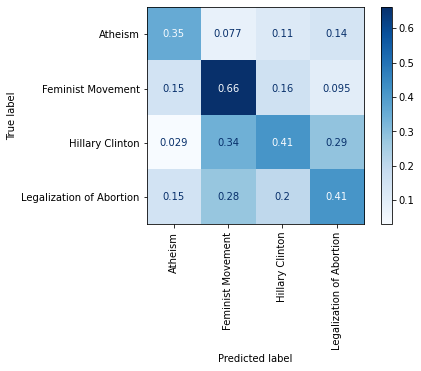

In [261]:
mapa_de_calor(cm/cm.astype(float).sum(axis=1), clf)

In [259]:
print("Acurracy: {:.2f} %".format(acc*100))
print("Cross Validation score: {:.2f} %".format(accs.mean()*100))
print("Standard Deviation: {:.2f} %".format(accs.std()*100), '\n')

Acurracy: 47.41 %
Cross Validation score: 37.75 %
Standard Deviation: 3.92 % 



<div style="text-align: right"><b> Jessenia Piza Londoño, Paula Lorena López Romero & Laura Alejandra Salazar Pérez. </b></div>